In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingRegressor, BaggingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, r2_score, mean_absolute_error, classification_report, plot_confusion_matrix, accuracy_score
from scipy.stats import reciprocal, randint
from sklearn.linear_model import LinearRegression,  Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler

# Exploración

In [2]:
df = pd.read_csv('winequality-red.csv', sep=';')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
df.quality.value_counts(sort=False)

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

In [4]:
X = df.drop(columns='quality')
sc = StandardScaler()
X = sc.fit_transform(X)
y = df.quality

In [5]:
y_list = [['Calidad con todos los valores', y],
          ['Calidad con 2 clases', pd.cut(y, bins=[0, 5.5, 10], labels=[0, 1])],
          ['Calidad con 3 clases uniforme', pd.cut(y, bins=[0, 4.5, 6.5, 10], labels=[0, 1, 2])],
          ['Calidad con 3 clases no uniforme', pd.cut(y, bins=[0, 5.5, 6.5, 10], labels=[0, 1, 2])],
          ['Calidad con 4 clases', pd.cut(y, bins=[0, 4.5, 5.5, 6.5, 10], labels=[0, 1, 2, 3])]
         ]

In [6]:
#Función para determinar y graficar las variables independientes mas importantes
def plot_feature_importances(clf, X_train, y_train=None, top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    clf.fit(X_train, y_train)
    feat_imp = pd.DataFrame({'importance': clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

# Modelos simples

## Regresión Logística

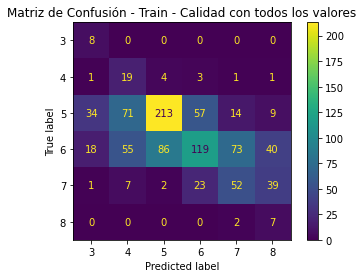

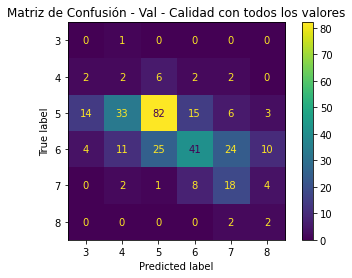

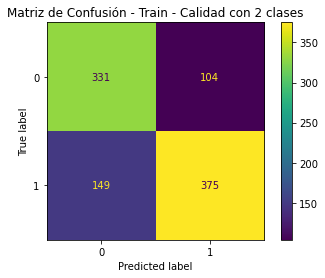

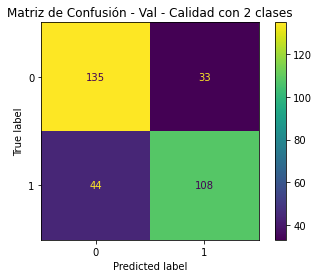

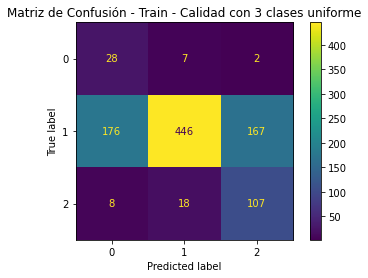

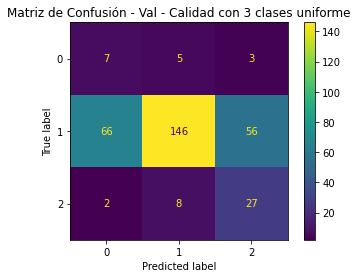

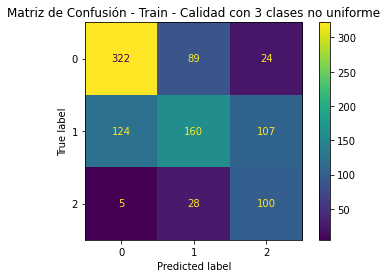

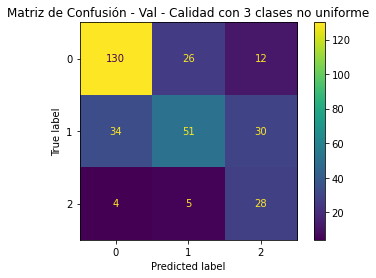

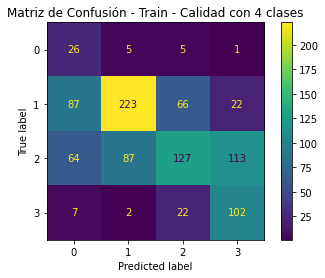

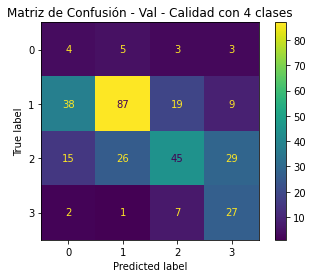

Wall time: 2min 11s


In [7]:
%%time
list_lr = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    log_est = LogisticRegression(class_weight='balanced', 
                                                multi_class='multinomial',
                                                solver='newton-cg',
                                                fit_intercept=True, 
                                                penalty='l2',
                                                max_iter=500)

    dists = {'C': reciprocal(1e-4, 1e4)}

    lr = RandomizedSearchCV(log_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    lr.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(lr, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(lr, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_lr.append([Y[0], 
                   f1_score(y_train, lr.predict(X_train), average='macro'),
                   f1_score(y_val, lr.predict(X_val), average='macro'),
                   accuracy_score(y_train, lr.predict(X_train)),
                   accuracy_score(y_val, lr.predict(X_val)),
                   f1_score(y_train, lr.predict(X_train), average=None),
                   f1_score(y_val, lr.predict(X_val), average=None)]
                  )

In [8]:
pd.set_option('display.max_colwidth', 100)
pd.options.display.float_format = '{:,.4f}'.format
labels_metrics = ['Variables', 'F1 Score Train', 'F1 Score Val','Accuracy Train','Accuracy Test','F1 Train Scores for each class', 'F1 Validation Scores for each class']
df_metrics_lr = pd.DataFrame(list_lr, columns=labels_metrics)
df_metrics_lr

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.3284,0.2880,0.4359,0.4531,"[0.2285714285714286, 0.20994475138121546, 0.6059743954480796, 0.40134907251264756, 0.39097744360...","[0.0, 0.06349206349206349, 0.6142322097378278, 0.4530386740331491, 0.4235294117647059, 0.1739130..."
1,Calidad con 2 clases,0.7356,0.7576,0.7362,0.7594,"[0.7234972677595628, 0.7477567298105683]","[0.7780979827089337, 0.7372013651877133]"
2,Calidad con 3 clases uniforme,0.4854,0.4261,0.6058,0.5625,"[0.2248995983935743, 0.707936507936508, 0.5232273838630807]","[0.15555555555555553, 0.6838407494145199, 0.43902439024390244]"
3,Calidad con 3 clases no uniforme,0.5851,0.6050,0.6069,0.6531,"[0.7268623024830699, 0.47904191616766467, 0.5494505494505494]","[0.7738095238095238, 0.5177664974619289, 0.5233644859813084]"
4,Calidad con 4 clases,0.4562,0.4346,0.4984,0.5094,"[0.23529411764705882, 0.6237762237762239, 0.4157119476268412, 0.549865229110512]","[0.10810810810810811, 0.6397058823529412, 0.4761904761904763, 0.5142857142857142]"


## Máquina de Soporte Vecotrial (SVM)

{'C': 450.72882279774365, 'gamma': 0.010456616389794584}


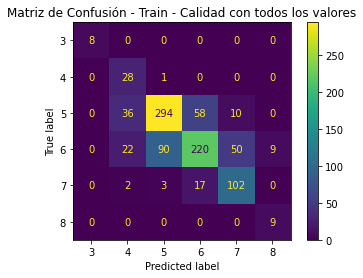

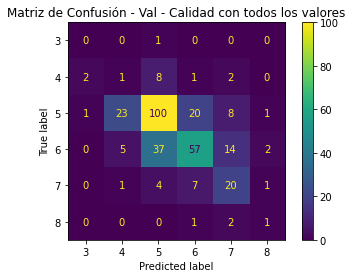

{'C': 3.624826025527982, 'gamma': 0.052556432655760814}


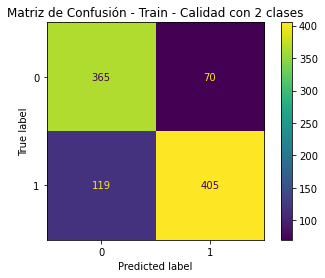

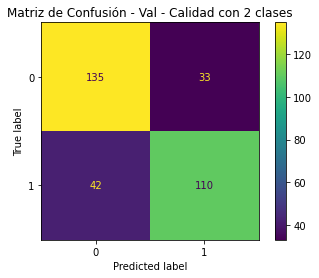

{'C': 0.25589400381671684, 'gamma': 0.44321586841400157}


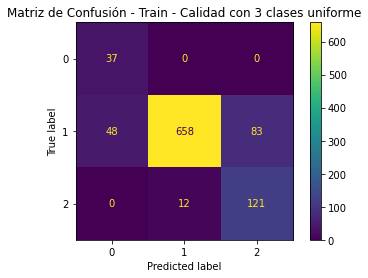

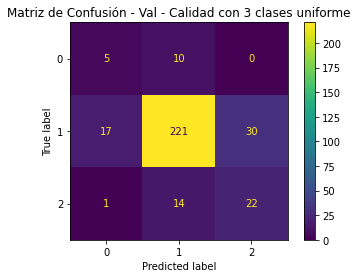

{'C': 7.633173422091099, 'gamma': 0.045967018758587726}


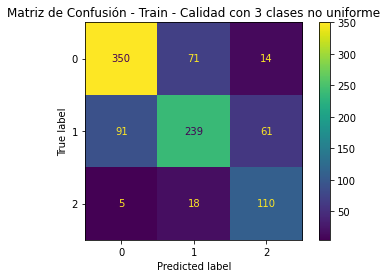

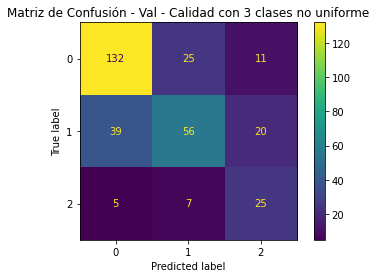

{'C': 27.976067027662584, 'gamma': 0.022157617097286076}


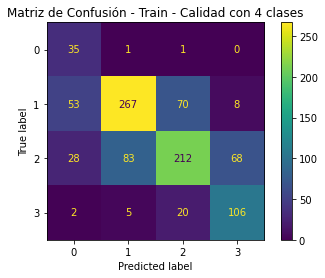

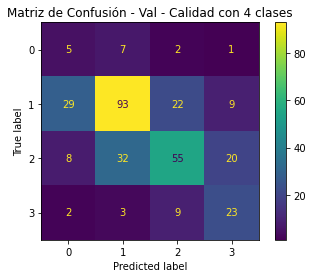

Wall time: 3min 57s


In [9]:
%%time
list_svm = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    svm_est = SVC(kernel='rbf', class_weight='balanced')

    dists = {'gamma':reciprocal(0.01, 100),'C': reciprocal(1e-4, 1e4)}

    svm = RandomizedSearchCV(svm_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    svm.fit(X_train, y_train)
    print(svm.best_params_)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(svm, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(svm, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_svm.append([Y[0], 
                   f1_score(y_train, svm.predict(X_train), average='macro'),
                   f1_score(y_val, svm.predict(X_val), average='macro'),
                   accuracy_score(y_train, svm.predict(X_train)),
                   accuracy_score(y_val, svm.predict(X_val)),
                   f1_score(y_train, svm.predict(X_train), average=None),
                   f1_score(y_val, svm.predict(X_val), average=None)]
                   )

In [10]:
df_metrics_svm = pd.DataFrame(list_svm, columns=labels_metrics)
df_metrics_svm

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.7080,0.3335,0.6893,0.5594,"[1.0, 0.4786324786324786, 0.748091603053435, 0.641399416909621, 0.7132867132867133, 0.6666666666...","[0.0, 0.045454545454545456, 0.6600660066006601, 0.5671641791044776, 0.5063291139240507, 0.222222..."
1,Calidad con 2 clases,0.8026,0.7642,0.8029,0.7656,"[0.7943416757344941, 0.8108108108108107]","[0.782608695652174, 0.7457627118644069]"
2,Calidad con 3 clases uniforme,0.7422,0.5397,0.8509,0.7750,"[0.6065573770491803, 0.9019876627827279, 0.7181008902077153]","[0.26315789473684204, 0.8615984405458089, 0.49438202247191015]"
3,Calidad con 3 clases no uniforme,0.7171,0.6189,0.7289,0.6656,"[0.7945516458569808, 0.6648122392211405, 0.6918238993710693]","[0.7674418604651163, 0.5517241379310345, 0.5376344086021506]"
4,Calidad con 4 clases,0.6110,0.4671,0.6465,0.5500,"[0.4516129032258064, 0.7082228116710875, 0.6109510086455332, 0.6730158730158731]","[0.16949152542372878, 0.6458333333333334, 0.541871921182266, 0.5111111111111112]"


## Árbol de Decisión

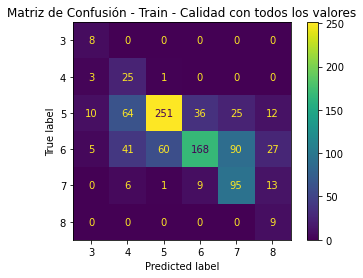

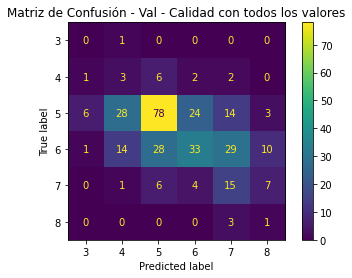

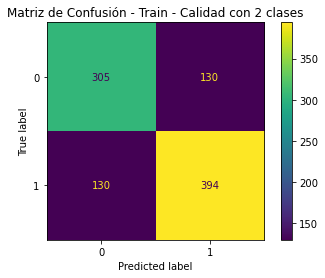

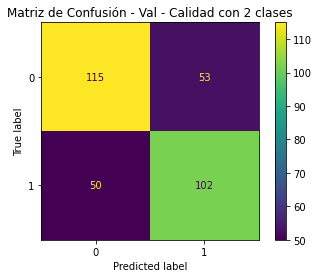

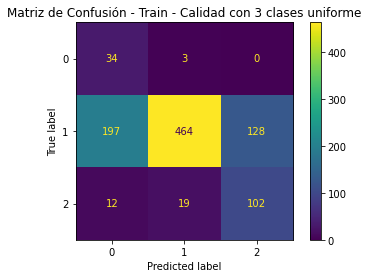

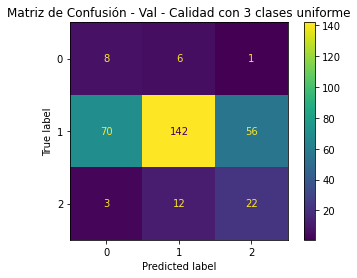

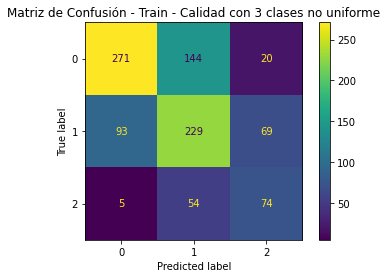

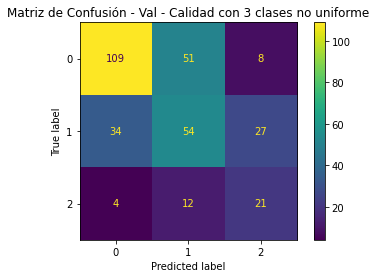

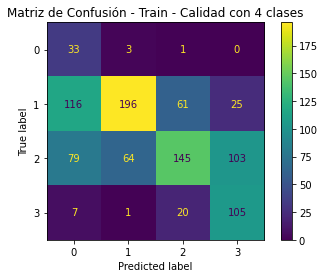

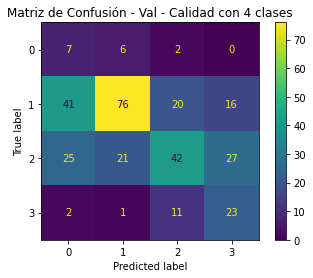

Wall time: 28.4 s


In [11]:
%%time
list_tree = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    tree_est = DecisionTreeClassifier(class_weight='balanced')

    dists = {'max_depth':range(2, 100),'min_samples_leaf': range(10, 1000)}

    tree = RandomizedSearchCV(tree_est, param_distributions = dists, n_iter=200, scoring='f1_macro')

    tree.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(tree, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(tree, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_tree.append([Y[0], 
                   f1_score(y_train, tree.predict(X_train), average='macro'),
                   f1_score(y_val, tree.predict(X_val), average='macro'),
                   accuracy_score(y_train, tree.predict(X_train)),
                   accuracy_score(y_val, tree.predict(X_val)),
                   f1_score(y_train, tree.predict(X_train), average=None),
                   f1_score(y_val, tree.predict(X_val), average=None)]
                   )

In [12]:
df_metrics_tree = pd.DataFrame(list_tree, columns=labels_metrics)
df_metrics_tree

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.4770,0.2395,0.5798,0.4062,"[0.47058823529411764, 0.30303030303030304, 0.7060478199718706, 0.5562913907284768, 0.56886227544...","[0.0, 0.0983606557377049, 0.5756457564575646, 0.37078651685393255, 0.31249999999999994, 0.08]"
1,Calidad con 2 clases,0.7265,0.6776,0.7289,0.6781,"[0.7011494252873564, 0.7519083969465649]","[0.6906906906906907, 0.6644951140065145]"
2,Calidad con 3 clases uniforme,0.5109,0.4032,0.6257,0.5375,"[0.24285714285714288, 0.7278431372549019, 0.5619834710743802]","[0.16666666666666666, 0.663551401869159, 0.37931034482758613]"
3,Calidad con 3 clases no uniforme,0.5780,0.5364,0.5985,0.5750,"[0.6741293532338308, 0.5599022004889975, 0.5]","[0.6920634920634922, 0.4655172413793104, 0.45161290322580644]"
4,Calidad con 4 clases,0.4695,0.4089,0.4995,0.4625,"[0.24264705882352938, 0.5921450151057402, 0.46925566343042074, 0.5737704918032787]","[0.15555555555555553, 0.5914396887159532, 0.4421052631578948, 0.44660194174757284]"


# Métodos de Ensamble

## Random Forest

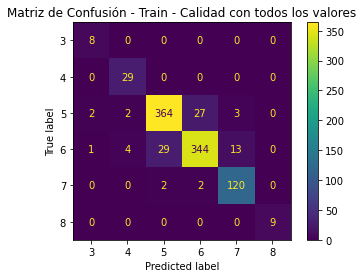

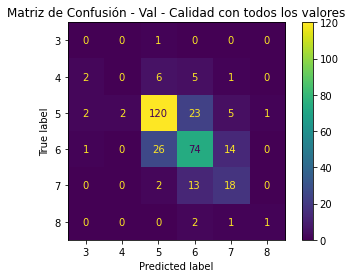

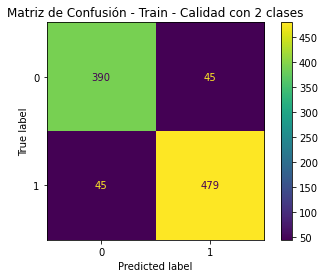

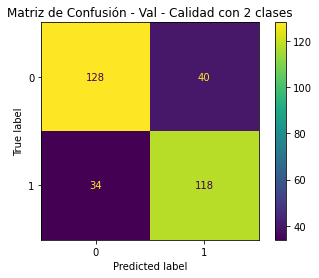

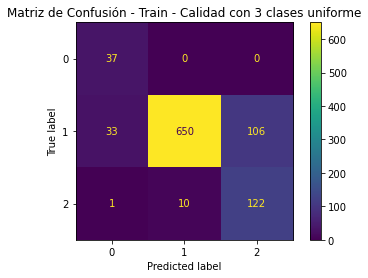

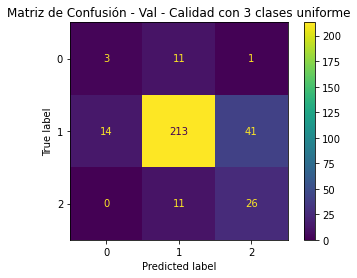

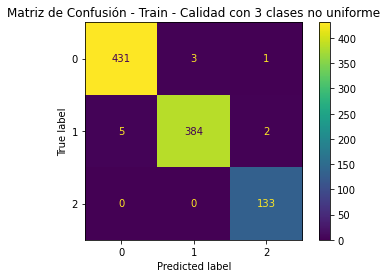

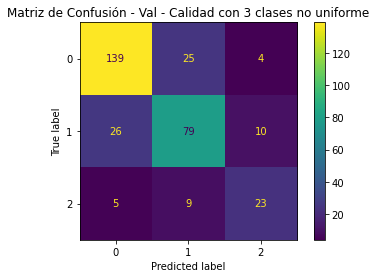

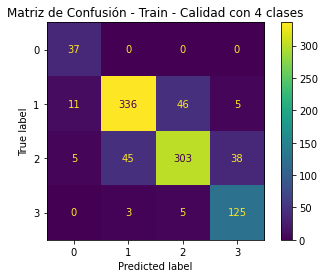

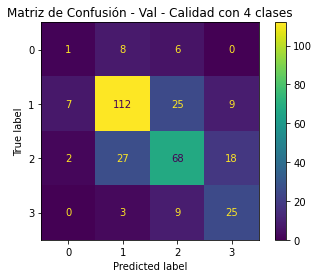

Wall time: 6min 2s


In [13]:
%%time
list_forest = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    forest_est = RandomForestClassifier(class_weight='balanced')

    dists = {'n_estimators':range(20, 100), 'max_depth':(2, 50), 'min_samples_leaf':range(2, 50)}
    
    forest = RandomizedSearchCV(forest_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    forest.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(forest, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(forest, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_forest.append([Y[0], 
                   f1_score(y_train, forest.predict(X_train), average='macro'),
                   f1_score(y_val, forest.predict(X_val), average='macro'),
                   accuracy_score(y_train, forest.predict(X_train)),
                   accuracy_score(y_val, forest.predict(X_val)),
                   f1_score(y_train, forest.predict(X_train), average=None),
                   f1_score(y_val, forest.predict(X_val), average=None)]
                   )

In [14]:
df_metrics_forest = pd.DataFrame(list_forest, columns=labels_metrics)
df_metrics_forest

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.9150,0.3751,0.9114,0.6656,"[0.8421052631578948, 0.90625, 0.9180327868852459, 0.9005235602094241, 0.923076923076923, 1.0]","[0.0, 0.0, 0.7792207792207791, 0.6379310344827587, 0.4999999999999999, 0.3333333333333333]"
1,Calidad con 2 clases,0.9053,0.7685,0.9062,0.7688,"[0.896551724137931, 0.9141221374045801]","[0.7757575757575756, 0.7612903225806452]"
2,Calidad con 3 clases uniforme,0.7528,0.5099,0.8436,0.7562,"[0.6851851851851851, 0.8971704623878537, 0.6759002770083102]","[0.18750000000000003, 0.8469184890656064, 0.4952380952380953]"
3,Calidad con 3 clases no uniforme,0.9886,0.7124,0.9885,0.7531,"[0.9896670493685419, 0.9871465295629821, 0.9888475836431226]","[0.8224852071005917, 0.6929824561403509, 0.6216216216216216]"
4,Calidad con 4 clases,0.8314,0.4977,0.8352,0.6438,"[0.8222222222222222, 0.8593350383631713, 0.8134228187919463, 0.8305647840531561]","[0.08, 0.7392739273927392, 0.609865470852018, 0.5617977528089887]"


## Bagging de SVM

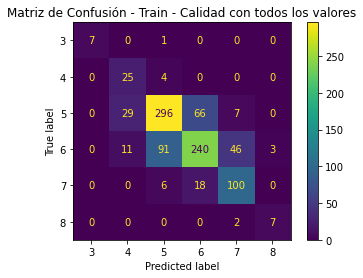

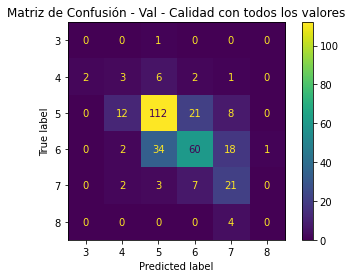

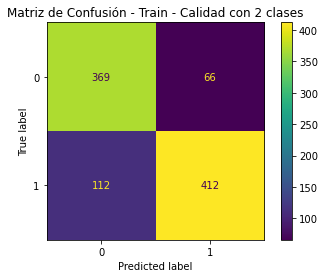

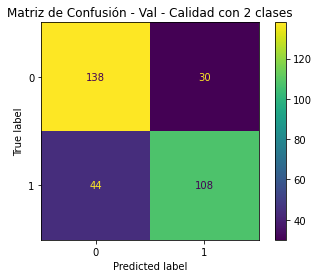

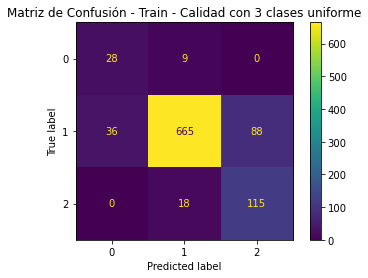

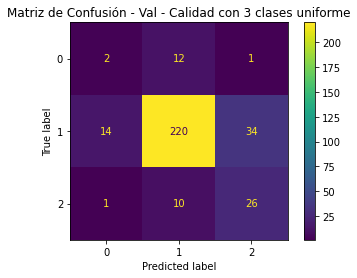

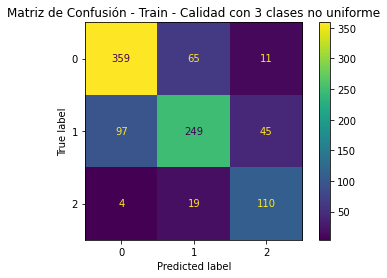

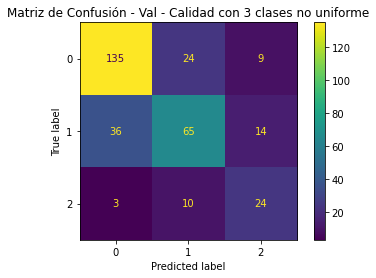

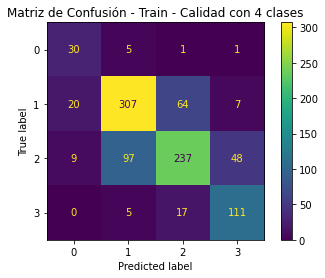

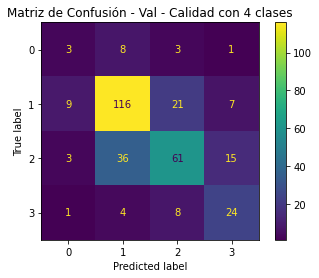

Wall time: 29min 11s


In [15]:
%%time
list_svm_bag = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    svm_bag_est = BaggingClassifier(base_estimator=SVC(kernel='rbf', C=10, gamma=0.05, class_weight='balanced'), max_samples=2/3)

    dists = {'n_estimators':range(20, 100)}
    
    svm_bag = GridSearchCV(svm_bag_est, param_grid = dists, scoring='f1_macro')

    svm_bag.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(svm_bag, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(svm_bag, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_svm_bag.append([Y[0], 
                   f1_score(y_train, svm_bag.predict(X_train), average='macro'),
                   f1_score(y_val, svm_bag.predict(X_val), average='macro'),
                   accuracy_score(y_train, svm_bag.predict(X_train)),
                   accuracy_score(y_val, svm_bag.predict(X_val)),
                   f1_score(y_train, svm_bag.predict(X_train), average=None),
                   f1_score(y_val, svm_bag.predict(X_val), average=None)]
                   )

In [16]:
df_metrics_svm_bag = pd.DataFrame(list_svm_bag, columns=labels_metrics)
df_metrics_svm_bag

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.7223,0.3310,0.7039,0.6125,"[0.9333333333333333, 0.5319148936170213, 0.7437185929648241, 0.6713286713286712, 0.7168458781362...","[0.0, 0.18181818181818182, 0.7249190938511326, 0.5853658536585366, 0.4941176470588235, 0.0]"
1,Calidad con 2 clases,0.8140,0.7667,0.8144,0.7688,"[0.8056768558951964, 0.8223552894211577]","[0.7885714285714285, 0.7448275862068965]"
2,Calidad con 3 clases uniforme,0.7123,0.5061,0.8425,0.7750,"[0.5544554455445544, 0.8980418636056718, 0.6845238095238095]","[0.125, 0.8627450980392157, 0.5306122448979592]"
3,Calidad con 3 clases no uniforme,0.7420,0.6561,0.7487,0.7000,"[0.8022346368715083, 0.6878453038674033, 0.7357859531772575]","[0.7894736842105263, 0.6074766355140188, 0.5714285714285715]"
4,Calidad con 4 clases,0.6972,0.5208,0.7143,0.6375,"[0.6249999999999999, 0.7561576354679803, 0.6676056338028169, 0.7399999999999999]","[0.19354838709677422, 0.7318611987381703, 0.5865384615384616, 0.5714285714285715]"
